### Import Libraries

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter # import warnings filter
simplefilter(action = 'ignore', category = FutureWarning) # ignore all future warnings

### Importing Dataset

In [2]:
heart = pd.read_csv(r'C:\Users\mboon\OneDrive\Desktop\Python Projects\Project 4\heart.csv')
print(heart.info())
heart.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<h3> Attribute Information from Kaggle </h3>
<br>
<li> Age: age of the patient [years] </li>
<li> Sex: sex of the patient [M: Male, F: Female] </li>
<li> ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] </li>
<li> RestingBP: resting blood pressure [mm Hg] </li>
<li> Cholesterol: serum cholesterol [mm/dl] </li>
<li> FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] </li>
<li> RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] </li>
<li> MaxHR: maximum heart rate achieved [Numeric value between 60 and 202] </li>
<li> ExerciseAngina: exercise-induced angina [Y: Yes, N: No] </li>
<li> Oldpeak: oldpeak = ST [Numeric value measured in depression] </li>
<li> ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping] </li>
<li> HeartDisease: output class [1: heart disease, 0: Normal] </li>

# EDA

In [3]:
# Replacing all ? values with NaN, and then filling NaN with column means
empty = np.sum(heart.values == '?') # In this case, there are no missing values
heart = heart.replace('?', np.nan).fillna(heart.mean())

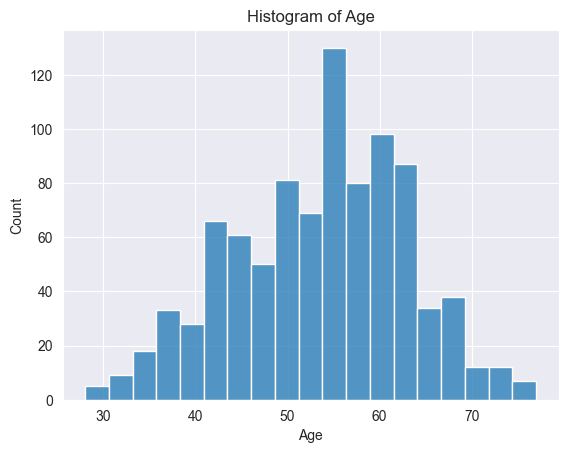

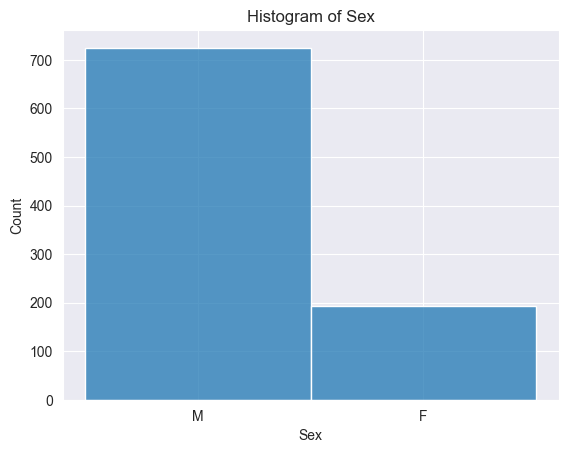

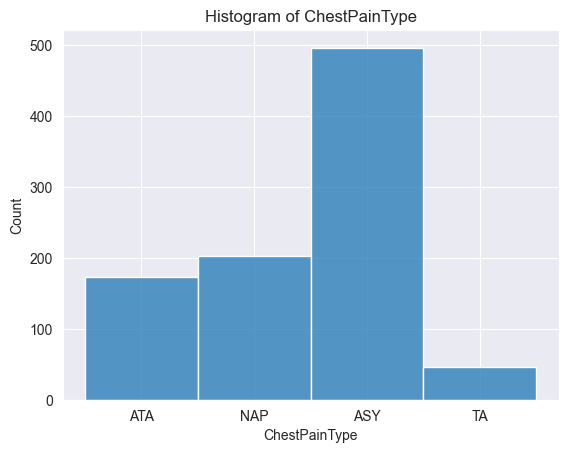

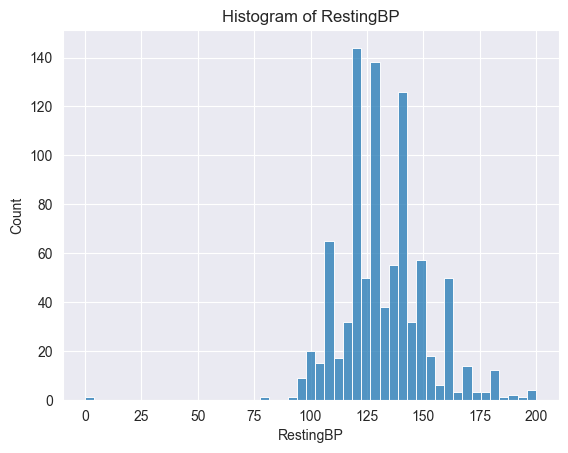

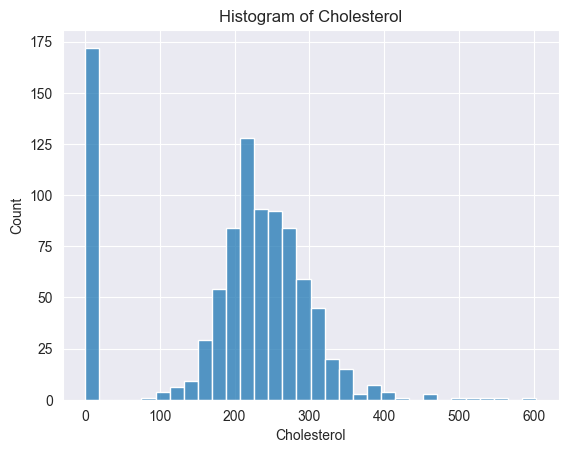

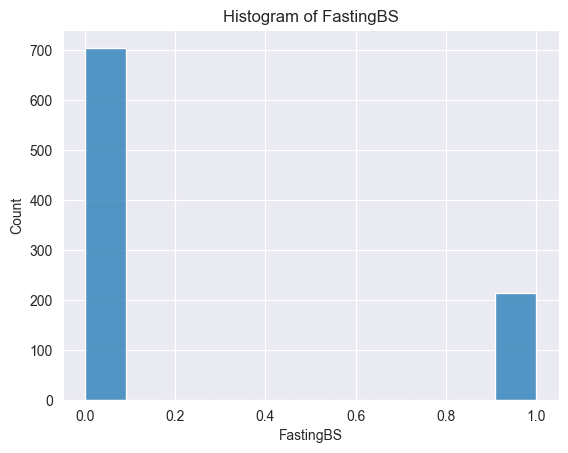

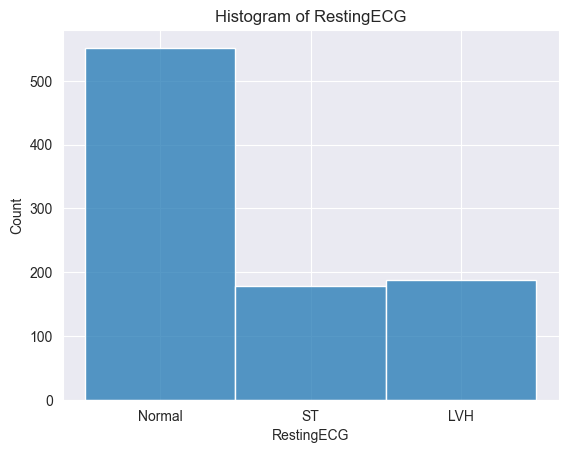

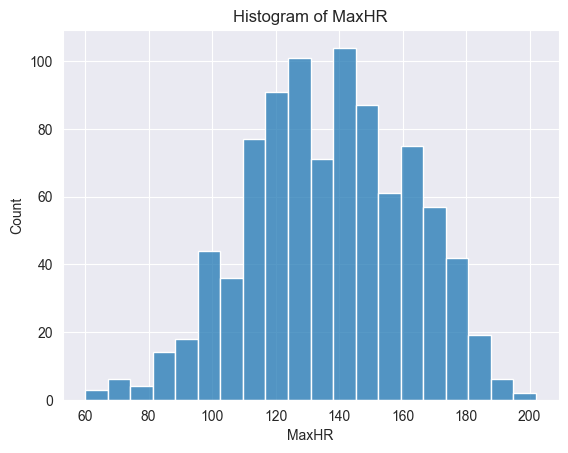

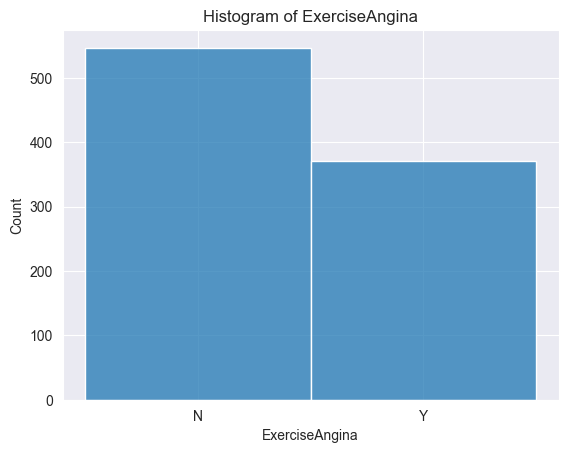

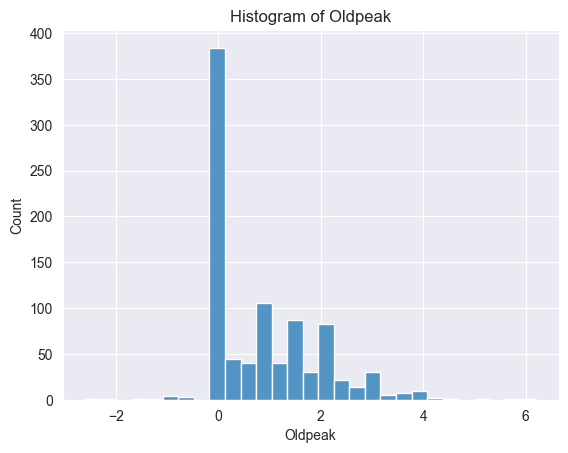

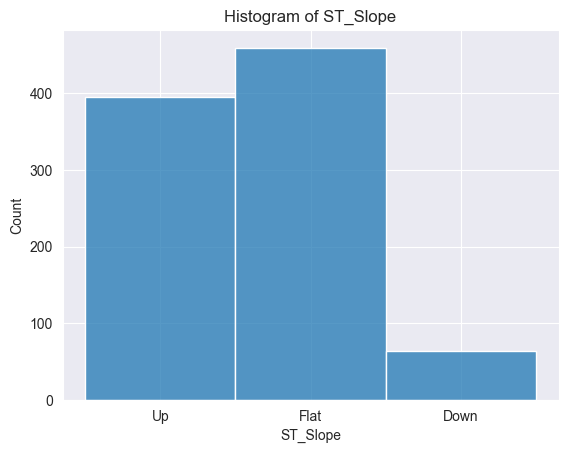

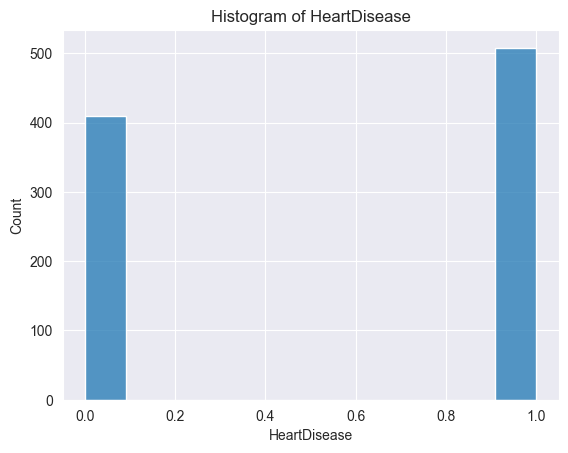

In [4]:
sns.set_style('darkgrid')
for column in heart.columns:
    sns.histplot(heart[column])
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Histogram of {column}')
    plt.show()

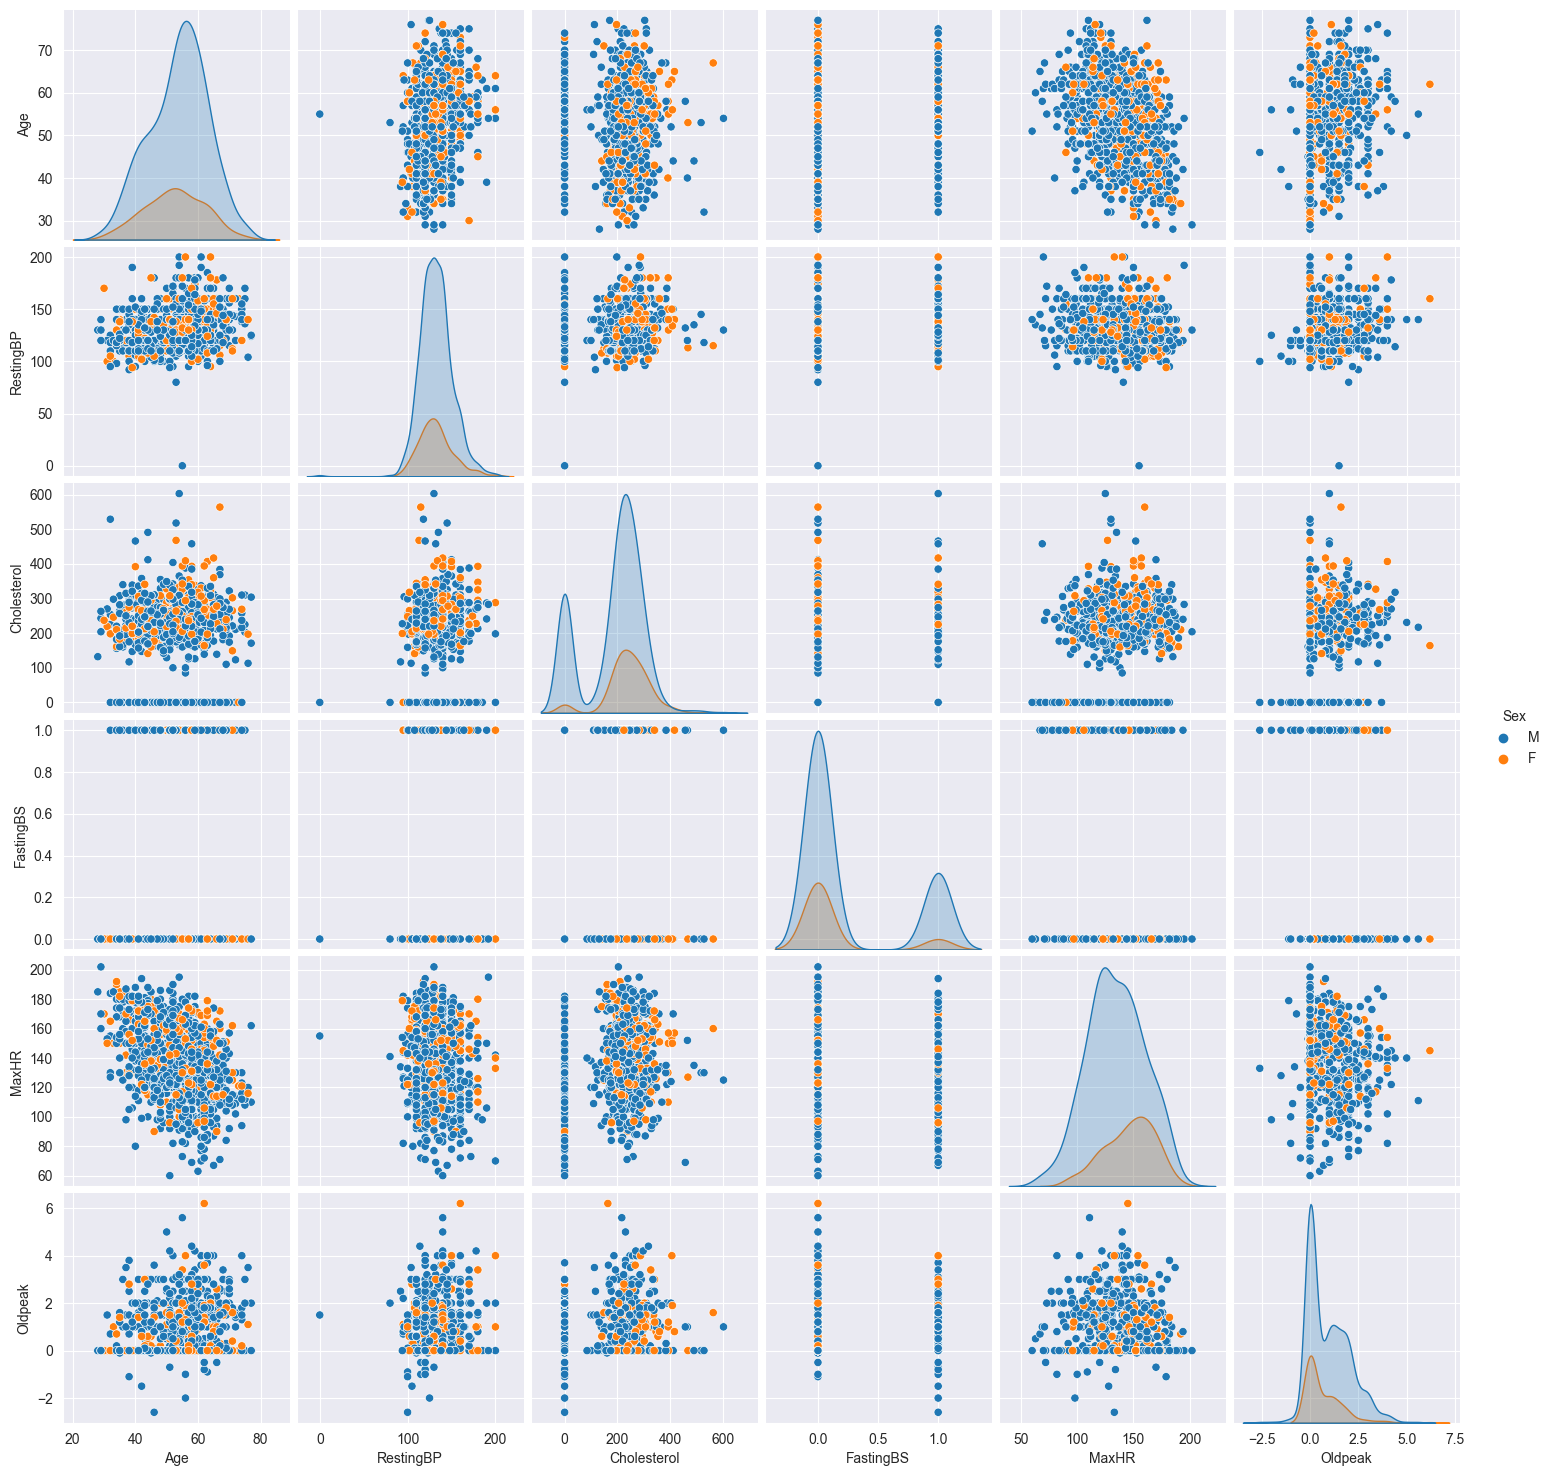

In [5]:
sns.pairplot(heart.drop('HeartDisease', axis = 1), hue = 'Sex')

### Feature Engineering

In [6]:
# Performing one-hot encoding to handle categorical values and standardizing the other column values
hot_heart = pd.get_dummies(heart, columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
scaler = StandardScaler()
scaled_col = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
hot_heart[scaled_col] = scaler.fit_transform(hot_heart[scaled_col])
hot_heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,0,1.382928,-0.832432,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,-0.478484,1.491752,-0.171961,0,0.754157,0.105664,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.129513,0.770188,0,-1.525138,-0.832432,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,-0.584556,0.302825,0.139040,0,-1.132156,0.574711,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,0.051881,0.951331,-0.034755,0,-0.581981,-0.832432,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


### Splitting Data into Training and Test Sets

In [7]:
# Assign variables X for input and y as expected output
X = hot_heart.iloc[:,:-1].values
y = hot_heart.iloc[:,-1].values

# Split dataset to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Model 1: <span style="color:green">K-Nearest Neighbors</span> 

In [8]:
# Testing which value of k gives lowest error
error_rate = []
for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred != y_test))

opt_k = error_rate.index(min(error_rate)) + 1
min_error = min(error_rate)

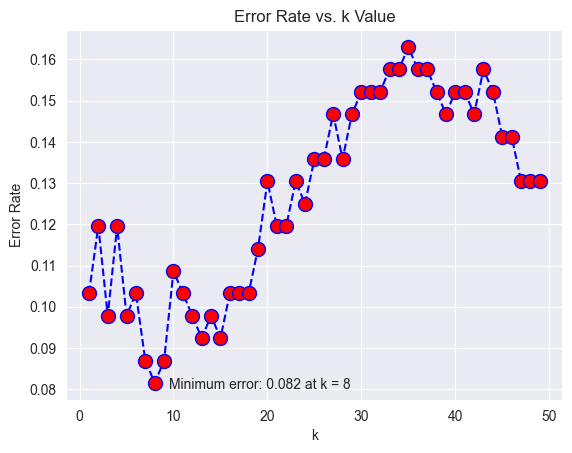

In [9]:
# Visualizing error rate
plt.plot(range(1,50), error_rate, color = 'blue', linestyle = 'dashed',
         marker = 'o', markerfacecolor= 'red', markersize = 10)
plt.title('Error Rate vs. k Value')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.text(
    opt_k + 1.5, min_error - 0.0005,
    f'Minimum error: {round(min_error, 3)} at k = {opt_k}', 
    ha = 'left', va = 'center'
         )

plt.show()

              precision    recall  f1-score   support

           0       0.88      0.98      0.93        96
           1       0.97      0.85      0.91        88

    accuracy                           0.92       184
   macro avg       0.93      0.92      0.92       184
weighted avg       0.92      0.92      0.92       184



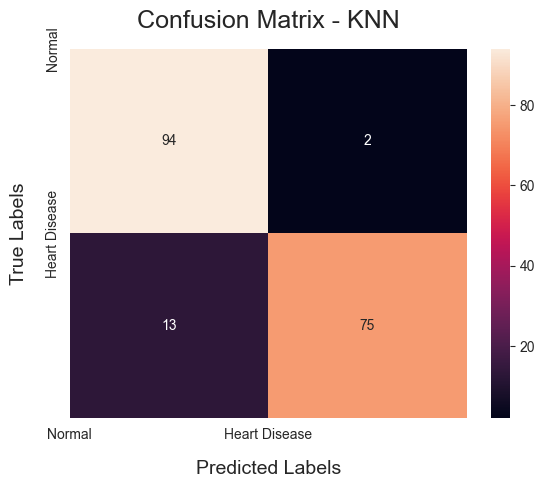

In [10]:
# Inputting the optimal k value for kNN and viewing the accuracy of the model
neigh = KNeighborsClassifier(n_neighbors = opt_k)
neigh.fit(X_train, y_train)
y_predict = neigh.predict(X_test)

# Plotting confusion matrix
cm = confusion_matrix(y_test, y_predict)
cmd = ConfusionMatrixDisplay(cm)

sns.heatmap(cm, annot = True, fmt = 'd')
plt.title('Confusion Matrix - KNN', fontsize = 18, pad = 15)
plt.xlabel('Predicted Labels', fontsize = 14, labelpad = 13)
plt.ylabel('True Labels', fontsize = 14, labelpad = 13)

# Set x-axis and y-axis labels
cm_labels = ['Normal', 'Heart Disease']
plt.xticks(np.arange(len(cm_labels)), cm_labels)
plt.yticks(np.arange(len(cm_labels)), cm_labels)

print(classification_report(y_test, y_predict)) 

In [11]:
# Comparing with cross validation
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)
cv_knn = KNeighborsClassifier(n_neighbors = opt_k)

scores = []
for train_index, val_index in cv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cv_knn.fit(X_train, y_train)
    score = cv_knn.score(X_val, y_val)
    scores.append(score)

mean_acc_knn = np.mean(scores)
std_acc_knn = np.std(scores)

# Print the mean accuracy score and standard deviation across all folds
print("Mean accuracy score: ", mean_acc_knn)
print("Standard deviation: ", std_acc_knn)

Mean accuracy score:  0.8986741519350216
Standard deviation:  0.030127484267164585


### Model 2: <span style="color:green">Neural Networks</span> 

In [12]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dropout

model = tf.keras.Sequential([
    layers.Dense(20, activation = 'relu', name = 'dense1'),
    Dropout(0.2),
    layers.Dense(25, activation = 'relu', name = 'dense2'),
    layers.Dense(45, activation = 'relu', name = 'dense3'),
    Dropout(0.5),
    layers.Dense(10, activation = 'relu', name = 'dense4'),
    layers.Dense(2, activation = 'sigmoid', name = 'fcl'),
])
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [13]:
model.fit(X_train, y_train, batch_size = 32, epochs = 100, verbose = 0)
loss_NN, acc_NN = model.evaluate(X_test, y_test, batch_size = 32, verbose = 0)

print('Loss =', loss_NN, 'Accuracy =', acc_NN)

Loss = 3.3157402867800556e-06 Accuracy = 1.0


### Model 3: <span style="color:green">Random Forest</span> 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {'n_estimators': range(1, 1000, 10)}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(param_distributions=rf_param_grid, estimator = rf,
                               scoring='accuracy', verbose=0,
                               n_iter=100, cv=4)
rf_random.fit(X_train, y_train)

best_params = rf_random.best_params_
print(f'Best parameters: {best_params}')

In [ ]:
best_n_estimators = best_params['n_estimators']
rf = RandomForestClassifier(n_estimators=best_n_estimators)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Compute the accuracy score
acc_RF = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc_RF:.4f}')

In [ ]:
from sklearn.metrics import log_loss

# Make predictions on the test set
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Compute the binary cross-entropy loss
loss_RF = log_loss(y_test, y_pred_prob)
print(f'Loss: {loss_RF:.4f}')

### Model 4: <span style="color:green">Decision Tree</span>

In [ ]:
# Testing for best hyperparameters for Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_scores = []
cr_scores = []
for cr in ['gini', 'entropy']:
    for i in range(1, len(hot_heart.columns)):
        dt_classifier = DecisionTreeClassifier(criterion = cr, max_features = i, random_state = 42)
        dt_classifier.fit(X_train, y_train)
        dt_scores.append(dt_classifier.score(X_test, y_test))
    print(f'Best max_features for {cr}: {np.argmax(dt_scores) + 1}')
    cr_scores.append(dt_scores[np.argmax(dt_scores)])
print(f'Best criterion: {"gini" if not np.argmax(cr_scores) else "entropy"}')

In [ ]:
dt = DecisionTreeClassifier(criterion = 'gini', max_features = 7, random_state = 42)
dt.fit(X_train, y_train)
acc_DT = dt.score(X_test, y_test)

print(acc_DT)

### Model 5: <span style="color:green">Support Vector Machine</span> 

In [ ]:
# Testing manually the best SVM parameter
from sklearn.svm import SVC
svc_scores = []
best_score = 0
best_kernel = ''
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_scores_c = []
    for ch in range(1,11):
        if kernels[i] == 'poly':
            svc_scores_poly = []
            for d in range(3,10):
                svc_classifier = SVC(kernel = kernels[i], C = ch, degree = d)
                svc_classifier.fit(X_train, y_train)
                svc_scores_poly.append(svc_classifier.score(X_test, y_test))
            best_poly_score = max(svc_scores_poly)
            best_poly_degree = np.argmax(svc_scores_poly) + 3
            svc_scores_c.append(best_poly_score)
            print(f'Best polynomial score: {best_poly_score}, degree: {best_poly_degree}')
        else:
            svc_classifier = SVC(kernel = kernels[i], C = ch)
            svc_classifier.fit(X_train, y_train)
            score = svc_classifier.score(X_test, y_test)
            svc_scores_c.append(score)
            print(f'Score for kernel {kernels[i]}, c={ch}: {score}')
            if score > best_score:
                best_score = score
                best_kernel = kernels[i]
                if kernels[i] == 'poly':
                    best_degree = best_poly_degree
                else:
                    best_degree = None

print(f'Best kernel: {best_kernel}')
if best_degree:
    print(f'Best degree: {best_degree}')
print(f'Best score: {best_score}')

In [ ]:
# Using GridSearchCV to compare with a library's performance of SVM parameters
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [2, 3, 4, 5]}

# Create a SVM classifier
svc_classifier = SVC()

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(svc_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f'Best parameters: {grid_search.best_params_}')

# Evaluate the model with the best hyperparameters on the test set
svc_classifier_best = grid_search.best_estimator_
svc_score = svc_classifier_best.score(X_test, y_test)
print(f'SVM score: {svc_score}')

In [ ]:
if svc_score > best_score:
    acc_SVM = svc_score
else:
    acc_SVM = best_score

print(acc_SVM)

In [ ]:
# Calculating SVM Loss
from sklearn.metrics import hinge_loss

svc_classifier = SVC(kernel='linear')
svc_classifier.fit(X_train, y_train)
y_pred = svc_classifier.predict(X_test)
loss_SVM = hinge_loss(y_test, svc_classifier.decision_function(X_test))

print(loss_SVM)

### Conclusion 

In [ ]:
models_final = ['K-Nearest Neighbors', 'Neural Networks', 'Random Forest', 'Decision Tree', 'Support Vector Machine']
loss_final = ['NA', "{:.2e}".format(loss_NN), "{:.2e}".format(loss_RF), 'NA', "{:.2e}".format(loss_SVM)]
acc_final = [mean_acc_knn, acc_NN, acc_RF, acc_DT, acc_SVM]
final_score = pd.DataFrame({'Loss': loss_final, 'Accuracy': acc_final}, index = models_final).round(3)

print(final_score.sort_values(by = ['Loss', 'Accuracy']))